In [1]:
import os, math, random
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import f1_score, matthews_corrcoef
from tqdm import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(42)


In [4]:
pre_base = r"C:\Users\HP\Documents\processedCOVID-19_Radiography_Dataset"

def load_split(split):
    rows = []
    for label in [0, 1]:
        folder = Path(pre_base) / split / str(label)
        for fname in os.listdir(folder):
            if fname.endswith(".npy"):
                rows.append([str(folder / fname), label])
    df = pd.DataFrame(rows, columns=["path", "label"])
    return df.sample(frac=1.0, random_state=42).reset_index(drop=True)

train_df = load_split("train")
val_df   = load_split("val")
test_df  = load_split("test")

print("Train:", train_df.label.value_counts().to_dict())
print("Val:", val_df.label.value_counts().to_dict())
print("Test:", test_df.label.value_counts().to_dict())


Train: {0: 12678, 1: 2613}
Val: {0: 2238, 1: 461}
Test: {0: 2633, 1: 542}


In [5]:
RATIO_POS_TO_NEG = 1.0

neg_df = train_df[train_df.label == 0]
pos_df = train_df[train_df.label == 1]

n_neg = len(neg_df)
n_pos = int(n_neg * RATIO_POS_TO_NEG)

pos_df_bal = pos_df.sample(
    n=n_pos,
    replace=len(pos_df) < n_pos,
    random_state=42
)

train_bal_df = (
    pd.concat([neg_df, pos_df_bal])
      .sample(frac=1.0, random_state=42)
      .reset_index(drop=True)
)

print("Balanced train:", train_bal_df.label.value_counts().to_dict())


Balanced train: {0: 12678, 1: 12678}


In [6]:
import cv2

class Covid4ChDataset(Dataset):
    def __init__(self, df, split="train"):
        self.df = df.reset_index(drop=True)
        self.split = split

    def __len__(self):
        return len(self.df)

    def _augment(self, x):
        if random.random() < 0.5:
            x = np.flip(x, axis=1)

        if random.random() < 0.5:
            angle = random.uniform(-7, 7)
            h, w, c = x.shape
            M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
            x = cv2.warpAffine(x, M, (w, h))
            x = x.reshape(h, w, c)

        return x

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = np.load(row["path"]).astype(np.float32)  # (H,W,4)
        y = row["label"]

        if self.split == "train":
            x = self._augment(x)

        x = x / 255.0
        x = (x - 0.5) / 0.5
        x = torch.from_numpy(x).permute(2, 0, 1)

        return x, torch.tensor(y, dtype=torch.long)


In [7]:
train_loader = DataLoader(
    Covid4ChDataset(train_bal_df, "train"),
    batch_size=8,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    Covid4ChDataset(val_df, "val"),
    batch_size=8,
    shuffle=False,
    num_workers=0
)


In [8]:
import timm

def make_xception_4ch():
    model = timm.create_model(
        "xception",
        pretrained=True,
        in_chans=4
    )
    in_features = model.get_classifier().in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_features, 1)
    )
    return model

model = make_xception_4ch().to(device)


C:\Users\HP\anaconda3\envs\XAI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\HP\anaconda3\envs\XAI\Lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [9]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.35, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        targets = targets.float().unsqueeze(1)
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        prob = torch.sigmoid(logits)
        pt = prob * targets + (1 - prob) * (1 - targets)
        weight = (self.alpha * targets + (1 - self.alpha) * (1 - targets))
        weight *= (1 - pt).pow(self.gamma)
        return (weight * bce).mean()

criterion = FocalLoss()


In [10]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-3,
    weight_decay=1e-4
)

def build_scheduler(optimizer, total_epochs):
    def lr_lambda(epoch):
        return 0.5 * (1 + math.cos(math.pi * epoch / total_epochs))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = build_scheduler(optimizer, total_epochs=20)


In [11]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    epochs=20,
    patience=4,
    ckpt_path="xception_4ch_lr3e3_do02.pth"
):
    best_mcc = -1
    wait = 0

    for epoch in range(epochs):
        # ---- TRAIN ----
        model.train()
        train_loss = 0

        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # ---- VALIDATE ----
        model.eval()
        probs, labels = [], []
        val_loss = 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                val_loss += criterion(logits, y).item()
                probs.extend(torch.sigmoid(logits).cpu().numpy().flatten())
                labels.extend(y.cpu().numpy())

        val_loss /= len(val_loader)
        preds = (np.array(probs) >= 0.5).astype(int)

        f1 = f1_score(labels, preds)
        mcc = matthews_corrcoef(labels, preds)

        print(f"Train={train_loss:.4f} | Val={val_loss:.4f} | F1={f1:.4f} | MCC={mcc:.4f}")

        scheduler.step()

        if mcc > best_mcc:
            best_mcc = mcc
            wait = 0
            torch.save(model.state_dict(), ckpt_path)
            print("✔ Saved best model")
        else:
            wait += 1
            if wait >= patience:
                print("⏹ Early stopping")
                break

    print("Best MCC:", best_mcc)


In [ ]:
train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    epochs=20,
    patience=4,
    ckpt_path="xception_4ch_lr3e3_do02.pth"
)


Epoch 1/20: 100%|██████████| 3170/3170 [10:03:38<00:00, 11.43s/it] 


Train=0.0653 | Val=0.0574 | F1=0.6159 | MCC=0.5368
✔ Saved best model


Epoch 2/20: 100%|██████████| 3170/3170 [9:57:55<00:00, 11.32s/it]  


Train=0.0514 | Val=0.0287 | F1=0.7106 | MCC=0.6553
✔ Saved best model


Epoch 3/20: 100%|██████████| 3170/3170 [10:04:13<00:00, 11.44s/it] 


Train=0.0419 | Val=0.0289 | F1=0.7769 | MCC=0.7296
✔ Saved best model


Epoch 4/20: 100%|██████████| 3170/3170 [10:03:10<00:00, 11.42s/it] 


Train=0.0387 | Val=0.0343 | F1=0.7826 | MCC=0.7422
✔ Saved best model


Epoch 5/20: 100%|██████████| 3170/3170 [10:01:02<00:00, 11.38s/it] 


Train=0.0360 | Val=0.0217 | F1=0.7991 | MCC=0.7631
✔ Saved best model


Epoch 6/20: 100%|██████████| 3170/3170 [10:00:44<00:00, 11.37s/it] 


Train=0.0320 | Val=0.0166 | F1=0.8078 | MCC=0.7832
✔ Saved best model


Epoch 7/20: 100%|██████████| 3170/3170 [10:01:08<00:00, 11.38s/it] 


Train=0.0305 | Val=0.0227 | F1=0.8241 | MCC=0.7878
✔ Saved best model


Epoch 8/20:   0%|          | 3/3170 [00:34<10:05:45, 11.48s/it]

In [11]:
start_epoch = 8   # resume from epoch 8

for _ in range(start_epoch):
    scheduler.step()

print(f"✔ Scheduler advanced to epoch {start_epoch}")


✔ Scheduler advanced to epoch 8


C:\Users\HP\anaconda3\envs\XAI\Lib\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


In [12]:
from sklearn.metrics import f1_score, matthews_corrcoef
from tqdm import tqdm
import numpy as np

def resume_training(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    start_epoch,
    total_epochs=20,
    patience=4,
    ckpt_path="xception_4ch_lr3e3_do02.pth"
):
    best_mcc = -1
    wait = 0

    for epoch in range(start_epoch, total_epochs):
        # ---- TRAIN ----
        model.train()
        train_loss = 0.0

        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}"):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # ---- VALIDATION ----
        model.eval()
        probs, labels = [], []
        val_loss = 0.0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                val_loss += criterion(logits, y).item()
                probs.extend(torch.sigmoid(logits).cpu().numpy().flatten())
                labels.extend(y.cpu().numpy())

        val_loss /= len(val_loader)
        preds = (np.array(probs) >= 0.5).astype(int)

        f1 = f1_score(labels, preds)
        mcc = matthews_corrcoef(labels, preds)

        print(
            f"Epoch {epoch+1}: "
            f"Train={train_loss:.4f} | "
            f"Val={val_loss:.4f} | "
            f"F1={f1:.4f} | "
            f"MCC={mcc:.4f}"
        )

        scheduler.step()

        if mcc > best_mcc:
            best_mcc = mcc
            wait = 0
            torch.save(model.state_dict(), ckpt_path)
            print("✔ Saved best model")
        else:
            wait += 1
            if wait >= patience:
                print("⏹ Early stopping triggered")
                break

    print("Training completed. Best MCC:", best_mcc)


In [13]:
resume_training(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    start_epoch=8,
    total_epochs=20,
    patience=4,
    ckpt_path="xception_4ch_lr3e3_do02.pth"
)


Epoch 9/20: 100%|██████████| 3170/3170 [13:43:46<00:00, 15.59s/it]  


Epoch 9: Train=0.0640 | Val=0.0324 | F1=0.6783 | MCC=0.6334
✔ Saved best model


Epoch 10/20: 100%|██████████| 3170/3170 [14:16:06<00:00, 16.20s/it]  


Epoch 10: Train=0.0463 | Val=0.0250 | F1=0.7648 | MCC=0.7173
✔ Saved best model


Epoch 11/20: 100%|██████████| 3170/3170 [14:28:46<00:00, 16.44s/it]  


Epoch 11: Train=0.0386 | Val=0.0235 | F1=0.6904 | MCC=0.6772


Epoch 12/20: 100%|██████████| 3170/3170 [14:21:22<00:00, 16.30s/it]  


Epoch 12: Train=0.0351 | Val=0.0424 | F1=0.7532 | MCC=0.7149


Epoch 13/20: 100%|██████████| 3170/3170 [14:17:56<00:00, 16.24s/it]  


Epoch 13: Train=0.0309 | Val=0.0178 | F1=0.7841 | MCC=0.7580
✔ Saved best model


Epoch 14/20: 100%|██████████| 3170/3170 [14:20:14<00:00, 16.28s/it]  


Epoch 14: Train=0.0265 | Val=0.0171 | F1=0.8471 | MCC=0.8162
✔ Saved best model


Epoch 15/20: 100%|██████████| 3170/3170 [14:21:38<00:00, 16.31s/it]  


Epoch 15: Train=0.0228 | Val=0.0291 | F1=0.8132 | MCC=0.7787


Epoch 16/20: 100%|██████████| 3170/3170 [14:42:34<00:00, 16.70s/it]  


Epoch 16: Train=0.0176 | Val=0.0207 | F1=0.8519 | MCC=0.8213
✔ Saved best model


Epoch 17/20: 100%|██████████| 3170/3170 [14:29:14<00:00, 16.45s/it]  


Epoch 17: Train=0.0134 | Val=0.0192 | F1=0.8626 | MCC=0.8339
✔ Saved best model


Epoch 18/20: 100%|██████████| 3170/3170 [14:18:05<00:00, 16.24s/it]  


Epoch 18: Train=0.0108 | Val=0.0172 | F1=0.8667 | MCC=0.8404
✔ Saved best model


Epoch 19/20: 100%|██████████| 3170/3170 [14:06:01<00:00, 16.01s/it]  


Epoch 19: Train=0.0086 | Val=0.0170 | F1=0.8626 | MCC=0.8365


Epoch 20/20: 100%|██████████| 3170/3170 [13:57:16<00:00, 15.85s/it]  


Epoch 20: Train=0.0074 | Val=0.0171 | F1=0.8692 | MCC=0.8432
✔ Saved best model
Training completed. Best MCC: 0.8432483372447367


In [14]:
import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, roc_auc_score,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Rebuild model (MUST match training)
model = make_xception_4ch().to(device)
model.load_state_dict(
    torch.load("xception_4ch_lr3e3_do02.pth", map_location=device)
)
model.eval()

print("✔ Loaded final tuned model")


C:\Users\HP\anaconda3\envs\XAI\Lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


✔ Loaded final tuned model


In [16]:
from torch.utils.data import DataLoader

test_dataset = Covid4ChDataset(test_df, split="test")


In [17]:
test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,   # IMPORTANT: never shuffle test
    num_workers=0
)


In [18]:
all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Evaluating on test set"):
        x = x.to(device)
        logits = model(x)
        probs = torch.sigmoid(logits).cpu().numpy().flatten()
        all_probs.extend(probs)
        all_labels.extend(y.numpy())

y_prob = np.array(all_probs)
y_true = np.array(all_labels)

print("Test label distribution:", np.bincount(y_true))
print("Prob range:", y_prob.min(), "→", y_prob.max())


Evaluating on test set: 100%|██████████| 397/397 [27:36<00:00,  4.17s/it]

Test label distribution: [2633  542]
Prob range: 2.0310295e-05 → 0.9977659


In [48]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, roc_auc_score,
    confusion_matrix
)

# threshold = 0.5
thr = 0.5
y_pred_05 = (y_prob >= thr).astype(int)

acc_05 = accuracy_score(y_true, y_pred_05)
prec_05 = precision_score(y_true, y_pred_05)
rec_05 = recall_score(y_true, y_pred_05)
f1_05 = f1_score(y_true, y_pred_05)
mcc_05 = matthews_corrcoef(y_true, y_pred_05)
auc = roc_auc_score(y_true, y_prob)

print("Evaluation @ threshold = 0.5")
print("--------------------------------")
print(f"Accuracy : {acc_05:.4f}")
print(f"Precision: {prec_05:.4f}")
print(f"Recall   : {rec_05:.4f}")
print(f"F1 Score : {f1_05:.4f}")
print(f"MCC      : {mcc_05:.4f}")
print(f"AUC      : {auc:.4f}")


Evaluation @ threshold = 0.5
--------------------------------
Accuracy : 0.9531
Precision: 0.8816
Recall   : 0.8376
F1 Score : 0.8590
MCC      : 0.8313
AUC      : 0.9830


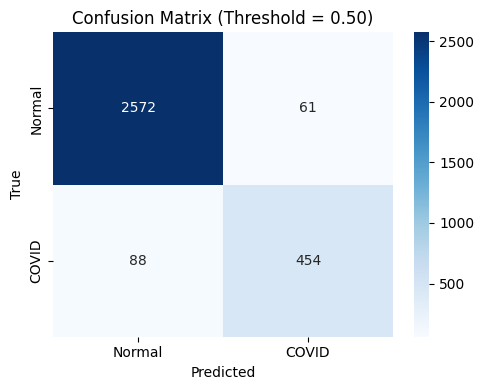

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------
# Threshold = 0.50
# -------------------------
thr = 0.50
y_pred_05 = (y_prob >= thr).astype(int)

# Confusion matrix
cm_05 = confusion_matrix(y_true, y_pred_05)

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_05,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "COVID"],
    yticklabels=["Normal", "COVID"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Threshold = 0.50)")
plt.tight_layout()
plt.show()


In [50]:
thr = 0.4
y_pred_04 = (y_prob >= thr).astype(int)

acc_04 = accuracy_score(y_true, y_pred_04)
prec_04 = precision_score(y_true, y_pred_04)
rec_04 = recall_score(y_true, y_pred_04)
f1_04 = f1_score(y_true, y_pred_04)
mcc_04 = matthews_corrcoef(y_true, y_pred_04)

print("Evaluation @ threshold = 0.4")
print("--------------------------------")
print(f"Accuracy : {acc_04:.4f}")
print(f"Precision: {prec_04:.4f}")
print(f"Recall   : {rec_04:.4f}")
print(f"F1 Score : {f1_04:.4f}")
print(f"MCC      : {mcc_04:.4f}")


Evaluation @ threshold = 0.4
--------------------------------
Accuracy : 0.9512
Precision: 0.8342
Recall   : 0.8911
F1 Score : 0.8617
MCC      : 0.8328


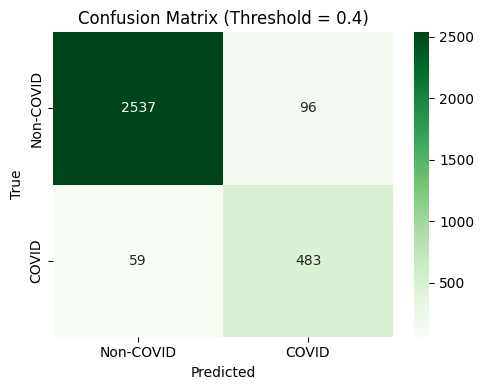

In [51]:
cm_04 = confusion_matrix(y_true, y_pred_04)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_04,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Non-COVID", "COVID"],
    yticklabels=["Non-COVID", "COVID"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Threshold = 0.4)")
plt.tight_layout()
plt.show()


In [22]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef
)

thresholds = np.arange(0.05, 1.00, 0.05)

rows = []

print("Threshold | Acc | Prec | Recall | F1 | MCC")
print("----------------------------------------------------")

for thr in thresholds:
    y_pred_thr = (y_prob >= thr).astype(int)

    acc = accuracy_score(y_true, y_pred_thr)
    prec = precision_score(y_true, y_pred_thr, zero_division=0)
    rec = recall_score(y_true, y_pred_thr)
    f1 = f1_score(y_true, y_pred_thr)
    mcc = matthews_corrcoef(y_true, y_pred_thr)

    rows.append([thr, acc, prec, rec, f1, mcc])

    print(f"{thr:8.2f} | {acc:5.3f} | {prec:5.3f} | {rec:6.3f} | {f1:5.3f} | {mcc:5.3f}")


Threshold | Acc | Prec | Recall | F1 | MCC
----------------------------------------------------
    0.05 | 0.705 | 0.366 |  0.994 | 0.535 | 0.482
    0.10 | 0.819 | 0.486 |  0.989 | 0.651 | 0.611
    0.15 | 0.877 | 0.583 |  0.980 | 0.731 | 0.695
    0.20 | 0.915 | 0.674 |  0.970 | 0.796 | 0.764
    0.25 | 0.925 | 0.710 |  0.952 | 0.813 | 0.781
    0.30 | 0.939 | 0.764 |  0.926 | 0.837 | 0.806
    0.35 | 0.948 | 0.811 |  0.910 | 0.857 | 0.828
    0.40 | 0.951 | 0.834 |  0.891 | 0.862 | 0.833
    0.45 | 0.952 | 0.851 |  0.873 | 0.862 | 0.833
    0.50 | 0.953 | 0.882 |  0.838 | 0.859 | 0.831
    0.55 | 0.954 | 0.904 |  0.815 | 0.857 | 0.831
    0.60 | 0.952 | 0.927 |  0.779 | 0.847 | 0.823
    0.65 | 0.947 | 0.937 |  0.738 | 0.826 | 0.803
    0.70 | 0.941 | 0.959 |  0.686 | 0.800 | 0.781
    0.75 | 0.938 | 0.981 |  0.651 | 0.783 | 0.770
    0.80 | 0.924 | 0.981 |  0.568 | 0.720 | 0.713
    0.85 | 0.911 | 0.989 |  0.483 | 0.649 | 0.656
    0.90 | 0.892 | 0.995 |  0.367 | 0.536 | 0.568
    

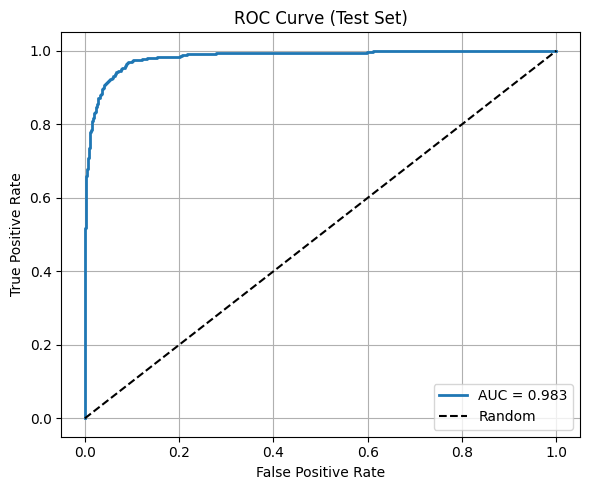

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef
)

thresholds = np.arange(0.05, 1.00, 0.05)
rows = []

for thr in thresholds:
    y_pred_thr = (y_prob >= thr).astype(int)

    acc = accuracy_score(y_true, y_pred_thr)
    prec = precision_score(y_true, y_pred_thr, zero_division=0)
    rec = recall_score(y_true, y_pred_thr)
    f1 = f1_score(y_true, y_pred_thr)
    mcc = matthews_corrcoef(y_true, y_pred_thr)

    rows.append([thr, acc, prec, rec, f1, mcc])

threshold_table = pd.DataFrame(
    rows,
    columns=["Threshold", "Accuracy", "Precision", "Recall", "F1", "MCC"]
)

threshold_table


,Threshold,Accuracy,Precision,Recall,F1,MCC
0,0.05,0.704567,0.365672,0.994465,0.534722,0.482356
1,0.10,0.819213,0.485507,0.988930,0.651276,0.610866
2,0.15,0.876850,0.582876,0.979705,0.730902,0.694885
3,0.20,0.914961,0.674359,0.970480,0.795764,0.763910
4,0.25,0.925354,0.709766,0.952030,0.813239,0.780756
5,0.30,0.938583,0.764079,0.926199,0.837364,0.805563
6,0.35,0.948346,0.810855,0.909594,0.857391,0.828013
7,0.40,0.951181,0.834197,0.891144,0.861731,0.832796
8,0.45,0.952126,0.850719,0.872694,0.861566,0.832730
9,0.50,0.953071,0.881553,0.837638,0.859035,0.831297


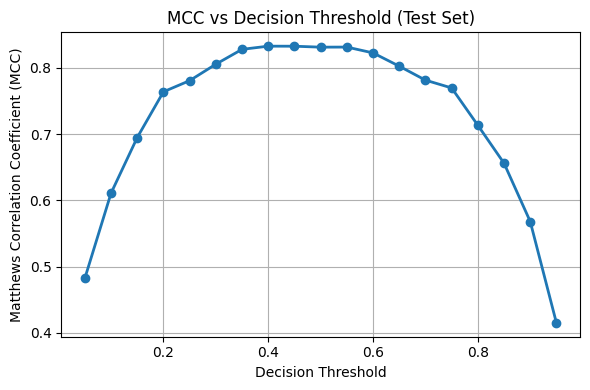

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(
    threshold_table["Threshold"],
    threshold_table["MCC"],
    marker="o",
    linewidth=2
)
plt.xlabel("Decision Threshold")
plt.ylabel("Matthews Correlation Coefficient (MCC)")
plt.title("MCC vs Decision Threshold (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
# =========================================================
# 1. Basic enhancement functions (same as train)

def apply_nclahe(img):
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(img)
    cl = cv2.normalize(cl, None, 0, 255, cv2.NORM_MINMAX)
    return cl.astype(np.uint8)

def bone_suppress(img):
    base = cv2.bilateralFilter(img, d=7, sigmaColor=30, sigmaSpace=30)
    detail = cv2.subtract(img, base)
    out = cv2.add(base, (0.18 * detail).astype(np.uint8))
    return out



# Lung mask (Otsu + keep_two_biggest) 

def otsu_lung_mask_simple(img_u8):
    im = img_u8.astype(np.float32)
    im = (im - im.min()) / max(1e-6, im.max() - im.min())
    blur = cv2.GaussianBlur(im, (11, 11), 0)
    thr = filters.threshold_otsu(1.0 - blur)
    mask = (1.0 - blur) > (thr * 0.9)
    mask = morphology.remove_small_objects(mask, 200)
    mask = morphology.remove_small_holes(mask, 200)
    mask = morphology.binary_closing(mask, morphology.disk(7))
    return mask.astype(np.uint8)

def keep_two_biggest_relaxed(mask):
    lbl = measure.label(mask)
    regions = measure.regionprops(lbl)
    if len(regions) == 0:
        return mask
    regions = sorted(regions, key=lambda r: r.area, reverse=True)[:2]
    out = np.zeros_like(mask, np.uint8)
    for r in regions:
        out[lbl == r.label] = 1
    out = morphology.binary_dilation(out, morphology.disk(5)).astype(np.uint8)
    return out

def safe_lung_mask(img_u8):
    h, w = img_u8.shape
    try:
        mask = otsu_lung_mask_simple(img_u8)
        mask = keep_two_biggest_relaxed(mask)
        area_frac = mask.sum() / (h * w)
        if not (0.05 < area_frac < 0.80):
            return np.ones_like(img_u8, dtype=np.float32)
        return mask.astype(np.float32)
    except:
        return np.ones_like(img_u8, dtype=np.float32)


In [29]:
# Extra channels: Frequency, Vessel, LBP

def frequency_enhance(img):
    f = np.fft.fft2(img.astype(np.float32))
    fshift = np.fft.fftshift(f)

    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2

    # mid-band radii ( r1=15, r2=60)
    r1 = int(min(rows, cols) * 15.0 / 512.0)
    r2 = int(min(rows, cols) * 60.0 / 512.0)
    r1 = max(r1, 1)

    Y, X = np.ogrid[:rows, :cols]
    D = np.sqrt((Y - crow) ** 2 + (X - ccol) ** 2)
    mask = np.logical_and(D > r1, D < r2).astype(np.float32)

    filtered = fshift * mask
    img_back = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered)))
    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
    return img_back.astype(np.uint8)

def vessel_enhance(img):
    v = frangi(img.astype(np.float64), scale_range=(1, 8))
    v = cv2.normalize(v, None, 0, 255, cv2.NORM_MINMAX)
    return v.astype(np.uint8)

def texture_lbp(img):
    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
    lbp = cv2.normalize(lbp, None, 0, 255, cv2.NORM_MINMAX)
    return lbp.astype(np.uint8)



# 4. Build 4-channel input (match training logic)
#    - Raw grayscale → CLAHE + bone_suppress
#    - Multiply by lung_mask (hard mask, soft)
#    - Frequency / Vessel / LBP  ROI
#    - Resize → 299x299, normalize

def make_4ch_tensor_from_raw(path, out_size=(299, 299)):
    """
    Returns:
      orig_rgb      : raw grayscale → RGB (H_raw, W_raw, 3)
      roi_resized   : ROI (masked) resized to out_size, uint8
      tensor4       : (1,4,H,W) float tensor on device
      lung_mask_raw : (H_raw, W_raw) float32 {0,1}
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)

    H_raw, W_raw = img.shape

    # lung mask on raw
    lung_mask = safe_lung_mask(img)  # float32 {0,1}

    # base enhancement (like training)
    img_base = apply_nclahe(img)
    img_base = bone_suppress(img_base)

    # hard ROI: zero outside lungs
    roi = (img_base.astype(np.float32) * lung_mask).astype(np.uint8)

    # extra channels
    freq   = frequency_enhance(roi)
    vessel = vessel_enhance(roi)
    lbp    = texture_lbp(roi)

    # resize all channels to out_size
    roi_r    = cv2.resize(roi, out_size, interpolation=cv2.INTER_AREA)
    freq_r   = cv2.resize(freq, out_size, interpolation=cv2.INTER_AREA)
    vessel_r = cv2.resize(vessel, out_size, interpolation=cv2.INTER_AREA)
    lbp_r    = cv2.resize(lbp, out_size, interpolation=cv2.INTER_AREA)

    # to [0,1]
    roi_f    = roi_r.astype(np.float32) / 255.0
    freq_f   = freq_r.astype(np.float32) / 255.0
    vessel_f = vessel_r.astype(np.float32) / 255.0
    lbp_f    = lbp_r.astype(np.float32) / 255.0

    stacked = np.stack([roi_f, freq_f, vessel_f, lbp_f], axis=0)  # (4,H,W)
    tensor  = torch.tensor(stacked, dtype=torch.float32).unsqueeze(0).to(device)
    # same normalization asตอนก่อน (0.5, 0.5)
    tensor  = (tensor - 0.5) / 0.5

    orig_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return orig_rgb, roi_r, tensor, lung_mask

In [30]:
# CAM energy inside / outside lungs 
def cam_lung_stats(cam, lung_mask):
    H, W = lung_mask.shape
    cam_res = cv2.resize(cam, (W, H))
    lm = lung_mask.astype(bool)

    total = cam_res.sum() + 1e-8
    inside = cam_res[lm].sum() / total
    outside = cam_res[~lm].sum() / total
    return inside, outside


In [31]:
# =========================================================
# 6. Visualization: raw+mask, heatmap, overlay
# =========================================================
def show_cam_triplet(orig_rgb, lung_mask, cam, label, prob, threshold):
    H, W = orig_rgb.shape[:2]
    cam_res = cv2.resize(cam, (W, H))
    cam_uint8 = (cam_res * 255).astype(np.uint8)

    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (0.4 * heatmap + 0.6 * orig_rgb).astype(np.uint8)

    lm_vis = cv2.resize(lung_mask.astype(np.float32), (W, H))
    lm_vis = (lm_vis * 255).astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(orig_rgb, cmap="gray")
    axes[0].imshow(lm_vis, cmap="jet", alpha=0.25)
    axes[0].set_title("Raw + Lung Mask")
    axes[0].axis("off")

    axes[1].imshow(heatmap)
    axes[1].set_title("Gradient-CAM Heatmap")
    axes[1].axis("off")

    axes[2].imshow(overlay)
    axes[2].set_title(f"Overlay — {label} ({prob*100:.1f}%, thr={threshold})")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

In [32]:

# prediction + gradient-based CAM 

def run_gradcam_4ch(model, img_path, threshold=0.40):
    model.eval()

    # ---------- build input ----------
    orig_rgb, roi_resized, tensor4, lung_mask = make_4ch_tensor_from_raw(img_path, out_size=(299, 299))

    # ---------- PREDICTION (clean, no_grad) ----------
    with torch.no_grad():
        logit = model(tensor4)
        prob = torch.sigmoid(logit).item()

    label = "COVID" if prob >= threshold else "Normal"
    print(f"\nImage: {os.path.basename(img_path)}")
    print(f"Prediction: {label}")
    print(f"COVID probability: {prob*100:.2f}% (threshold = {threshold})")

    # ---------- GRADIENT-BASED CAM ----------
    x = tensor4.clone().detach().requires_grad_(True)
    model.zero_grad()
    out = model(x)
    score = out.view(-1)[0]
    score.backward()

    grads = x.grad.detach()[0]   # (4,H,W)
    cam = grads.abs().mean(dim=0).cpu().numpy()  # (H,W) – average over channels
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)

    # CAM energy inside vs outside lungs 
    inside, outside = cam_lung_stats(cam, lung_mask)
    print(f"CAM energy inside lungs:  {inside*100:.1f}%")
    print(f"CAM energy outside lungs: {outside*100:.1f}%")

    # visualization 
    show_cam_triplet(orig_rgb, lung_mask, cam, label, prob, threshold)

    return {
        "orig_rgb": orig_rgb,
        "roi": roi_resized,
        "cam": cam,
        "lung_mask": lung_mask,
        "prob": prob,
        "label": label,
        "inside_frac": inside,
        "outside_frac": outside
    }

In [34]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split

# -----------------------
# PATHS
# -----------------------
DATASET_DIR = r"C:\Users\HP\Documents\COVID-19_Radiography_Dataset"
save_dir = r"C:\Users\HP\Documents\processedCOVID-19_Radiography_Dataset"
classes = {
    "COVID": 1,
    "Normal": 0,
    "Viral Pneumonia": 0,
    "Lung_Opacity": 0
}

rows = []

for cls_name, label in classes.items():
    img_dir = os.path.join(DATASET_DIR, cls_name, "images")
    mask_dir = os.path.join(DATASET_DIR, cls_name, "masks")

    img_paths = glob.glob(os.path.join(img_dir, "*.png")) + \
                glob.glob(os.path.join(img_dir, "*.jpg")) + \
                glob.glob(os.path.join(img_dir, "*.jpeg"))

    for img_path in img_paths:
        fname = os.path.basename(img_path)
        mask_path = os.path.join(mask_dir, fname)

        if os.path.exists(mask_path):
            rows.append([img_path, mask_path, label])

# Build DataFrame
df = pd.DataFrame(rows, columns=["img_path", "mask_path", "label"])

print("Total samples:", len(df))
print(df.head())


Total samples: 21165
                                            img_path  \
0  C:\Users\HP\Documents\COVID-19_Radiography_Dat...   
1  C:\Users\HP\Documents\COVID-19_Radiography_Dat...   
2  C:\Users\HP\Documents\COVID-19_Radiography_Dat...   
3  C:\Users\HP\Documents\COVID-19_Radiography_Dat...   
4  C:\Users\HP\Documents\COVID-19_Radiography_Dat...   

                                           mask_path  label  
0  C:\Users\HP\Documents\COVID-19_Radiography_Dat...      1  
1  C:\Users\HP\Documents\COVID-19_Radiography_Dat...      1  
2  C:\Users\HP\Documents\COVID-19_Radiography_Dat...      1  
3  C:\Users\HP\Documents\COVID-19_Radiography_Dat...      1  
4  C:\Users\HP\Documents\COVID-19_Radiography_Dat...      1  


In [36]:
import os, glob, random
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from skimage import filters, morphology, measure
from skimage.filters import frangi
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

===== RANDOM NORMAL =====

Image: Lung_Opacity-2611.png
Prediction: Normal
COVID probability: 10.69% (threshold = 0.4)
CAM energy inside lungs:  63.4%
CAM energy outside lungs: 36.6%


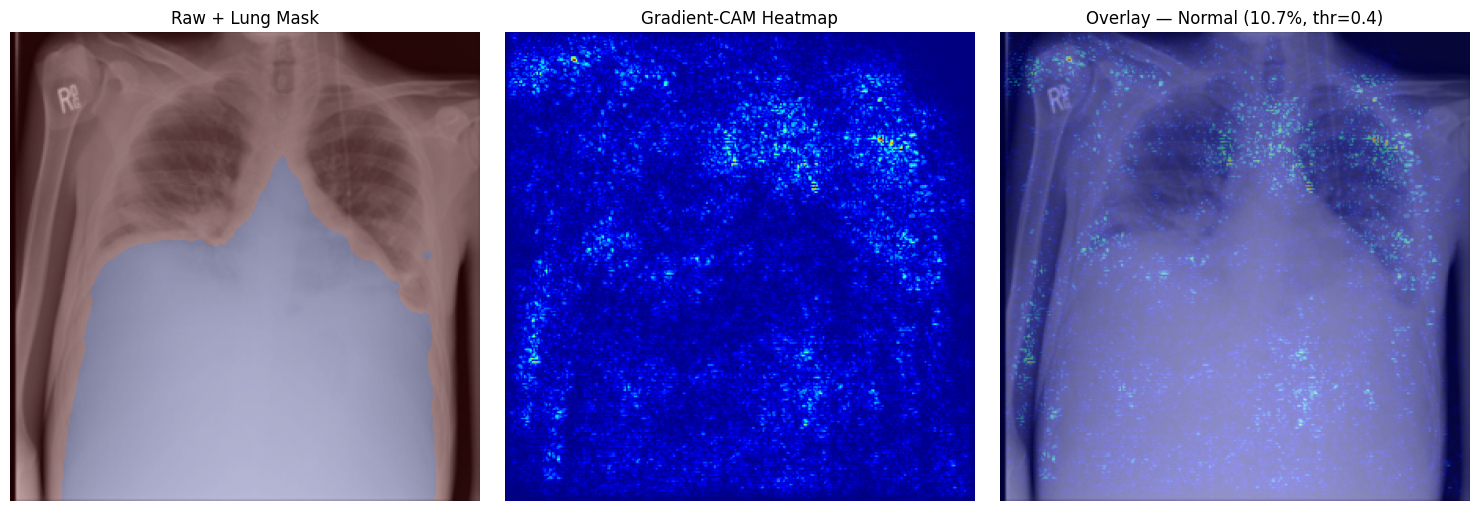


===== RANDOM COVID =====

Image: COVID-3306.png
Prediction: COVID
COVID probability: 72.14% (threshold = 0.4)
CAM energy inside lungs:  59.3%
CAM energy outside lungs: 40.7%


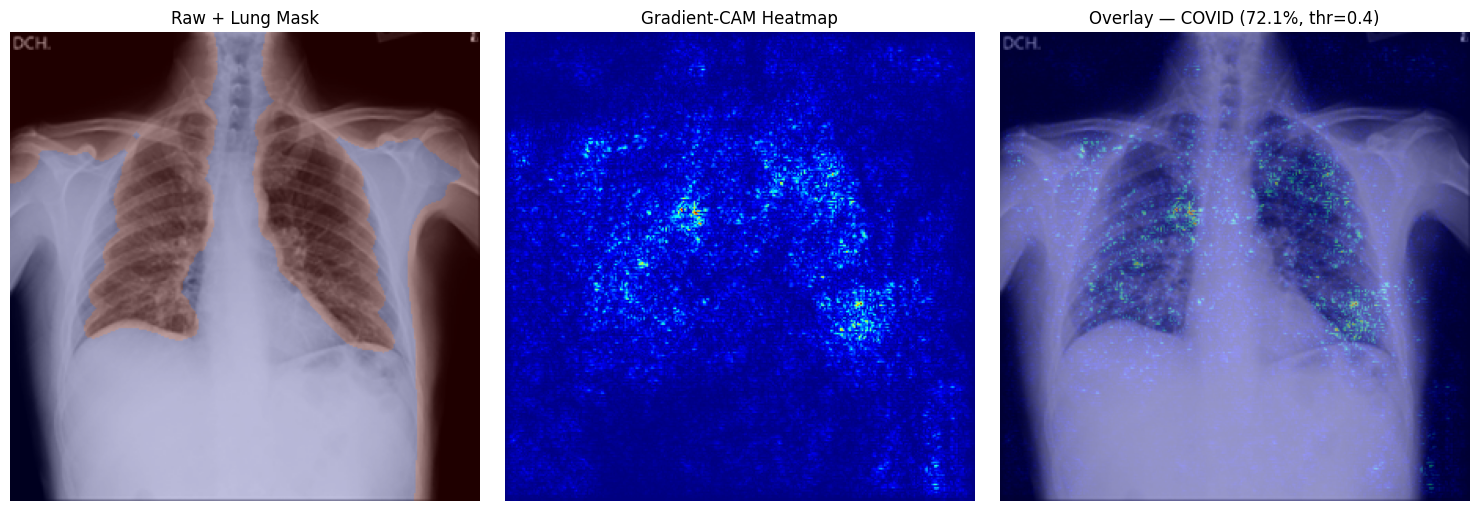

In [46]:
# =========================================================
# 8. Test on random Normal / COVID from RAW folders
# =========================================================
normal_list = glob.glob(r"C:\Users\HP\Documents\COVID-19_Radiography_Dataset\Lung_Opacity\images\*.png")
covid_list  = glob.glob(r"C:\Users\HP\Documents\COVID-19_Radiography_Dataset\COVID\images\*.png")

img_neg = random.choice(normal_list)
img_pos = random.choice(covid_list)

print("===== RANDOM NORMAL =====")
res_neg = run_gradcam_4ch(model, img_neg, threshold=0.40)

print("\n===== RANDOM COVID =====")
res_pos = run_gradcam_4ch(model, img_pos, threshold=0.40)

In [54]:
pip install torchinfo


Note: you may need to restart the kernel to use updated packages.


In [55]:
from torchinfo import summary

# Make sure model is already created
# model = make_xception_4ch().to(device)

summary(
    model,
    input_size=(1, 4, 299, 299),  # (batch, channels, height, width)
    col_names=[
        "input_size",
        "output_size",
        "num_params",
        "kernel_size",
        "mult_adds"
    ],
    depth=3
)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Xception                                 [1, 4, 299, 299]          [1, 1]                    --                        --                        --
├─Conv2d: 1-1                            [1, 4, 299, 299]          [1, 32, 149, 149]         1,152                     [3, 3]                    25,575,552
├─BatchNorm2d: 1-2                       [1, 32, 149, 149]         [1, 32, 149, 149]         64                        --                        64
├─ReLU: 1-3                              [1, 32, 149, 149]         [1, 32, 149, 149]         --                        --                        --
├─Conv2d: 1-4                            [1, 32, 149, 149]         [1, 64, 147, 147]         18,432                    [3, 3]                    398,297,088
├─BatchNorm2d: 1-5                       [1, 64, 147, 147]         [1, 64, 147, 147]    